In [14]:
from deepchecks.checks import CalibrationScore
from deepchecks.base import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings

def custom_formatwarning(msg, *args, **kwargs):
    # ignore everything except the message
    return str(msg) + '\n'

warnings.formatwarning = custom_formatwarning

# Binary Classification 

## Load data

The dataset is the adult dataset which can be downloaded from the UCI machine learning repository.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [15]:
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
test_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

test_df[label_name] = test_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
test_df[label_name] = encoder.transform(test_df[label_name])

In [16]:
from deepchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label_name=label_name, cat_features=cat_features)
test_ds = Dataset(test_df, label_name=label_name, cat_features=cat_features)

numeric_features = list(set(train_ds.features) - set(cat_features))

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = SimpleImputer()
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder())]
)

train_ds.features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

model = Pipeline(steps=[("preprocessing", preprocessor), ("model", RandomForestClassifier(max_depth=5, n_jobs=-1))])
model = model.fit(train_ds.features_columns, train_ds.label_col)

Calibration Metric

Calculate the calibration curve with brier score for each class.

Calibration curves (also known as reliability diagrams) compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the true frequency of the positive label against its predicted probability, for binned predictions.

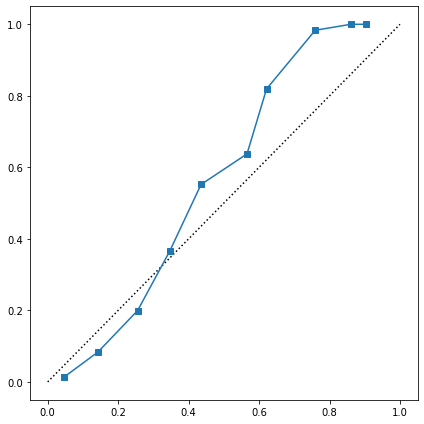

The Brier score metric may be used to assess how well a classifier is calibrated. For more info, please visit https://en.wikipedia.org/wiki/Brier_score

In [18]:
check = CalibrationScore()
check.run(test_ds, model)

# Multi-class classification 

In [19]:
iris = load_iris(as_frame=True)
clf = LogisticRegression(max_iter=20)
frame = iris.frame
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=55)
clf.fit(X_train, y_train)
ds = Dataset(pd.concat([X_test, y_test], axis=1), 
            features=iris.feature_names,
            label_name='target')

Calibration Metric

Calculate the calibration curve with brier score for each class.

Calibration curves (also known as reliability diagrams) compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the true frequency of the positive label against its predicted probability, for binned predictions.

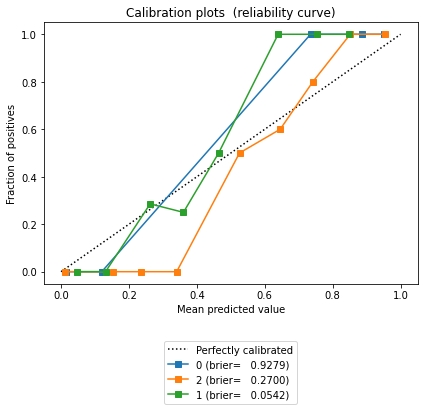

The Brier score metric may be used to assess how well a classifier is calibrated. For more info, please visit https://en.wikipedia.org/wiki/Brier_score

In [20]:
check = CalibrationScore()
check.run(ds, clf)